# DiploDatos Kaggle Competition


Presentamos un código creado como ejemplo de base para la competición.

Deben:

- Explorar los datos y aprender de ellos.
- Probar diferentes modelos y ver cuáles ajustan mejor dado los datos.
- **Obtener una accuracy mejor que la que se presenta en este ejemplo.**
- Tratar de obtener la accuracy más alta posible!
- Discutir la elección de modelo.

El análisis exploratorio y el preprocesamiento de los datos queda a libertad de cada grupo y no deben quedarse con este simple ejemplo.

In [1]:
import pandas as pd
from pandas import MultiIndex, Int16Dtype
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

import missingno as msno
import seaborn as sns

xgboost.set_config(verbosity=0)

# 1. Se importan los datos del archivo 'train.csv' para comenzar con el análisis exploratorio

In [2]:
df = pd.read_csv('train.csv')
print(df.columns)
print(df.shape)
print(df.info())

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')
(7823, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7823 entries, 0 to 7822
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   7823 non-null   int64  
 1   HomePlanet    7644 non-null   object 
 2   CryoSleep     7627 non-null   object 
 3   Cabin         7639 non-null   object 
 4   Destination   7663 non-null   object 
 5   Age           7661 non-null   float64
 6   VIP           7639 non-null   object 
 7   RoomService   7669 non-null   float64
 8   FoodCourt     7668 non-null   float64
 9   ShoppingMall  7635 non-null   float64
 10  Spa           7665 non-null   float64
 11  VRDeck        7654 non-null   float64
 12  Name          7639 non-null   object 
 13  Transported   7823 non-n

## 1.1 - Es importante reducir el número de features aplicando un criterio de lógica basado en la definición de las columnas en el dataset

## Definición de las features según Kaggle

- PassengerId - A unique Id for each passenger. 
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

## 1.2- La columna 'PassengerId' y 'Name' se pueden eliminar, dado que es un feature único de registro que no debe repetirse.

In [3]:
cols_to_drop = ['PassengerId','Name']
df.drop(cols_to_drop, axis=1, inplace=True)
df.columns

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported'],
      dtype='object')

## 1.3- Análisis de datos faltantes

In [4]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7823 entries, 0 to 7822
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    7644 non-null   object 
 1   CryoSleep     7627 non-null   object 
 2   Cabin         7639 non-null   object 
 3   Destination   7663 non-null   object 
 4   Age           7661 non-null   float64
 5   VIP           7639 non-null   object 
 6   RoomService   7669 non-null   float64
 7   FoodCourt     7668 non-null   float64
 8   ShoppingMall  7635 non-null   float64
 9   Spa           7665 non-null   float64
 10  VRDeck        7654 non-null   float64
 11  Transported   7823 non-null   int64  
dtypes: float64(6), int64(1), object(5)
memory usage: 733.5+ KB
None
               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  7661.000000   7669.000000   7668.000000   7635.000000   7665.000000   
mean     28.879389    226.078237    455.643062    172.600393    30

<AxesSubplot:>

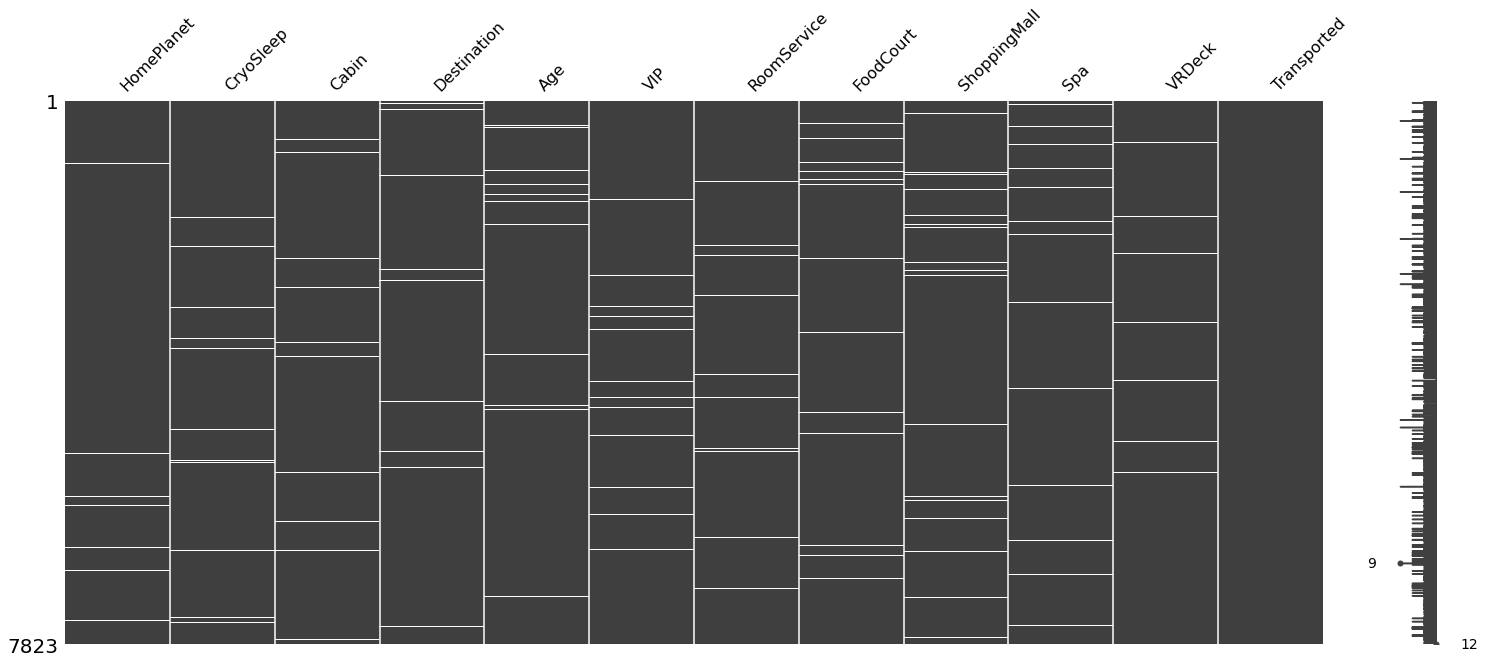

In [5]:
msno.matrix(df)

### **Acá se observa que hay una diversidad de datos faltantes en el dataset, todos ellos correspondientes a las features. La variable target ('Transported') está completa, lo cual ya elimina un problema.** 

### - Utilizaré un criterio conservador de imputación de datos, en donde si la evidencia y/o lógica de imputación no resulta segura, prefiero eliminar el dato completo.

### - En esa línea, creo que una feature crítica es 'CryoSleep', dado que en principio una persona durmiendo en condiciones criogénicas tiene muy bajas chances de no ser teletransportado, a no ser que alguien se dedique a rescatarlo. Entonces imputar 'CryoSleep' de manera fundamentada es muy importante a los fines del modelo en desarrollo. 

### - El criterio de analizar si la persona gastó o no gastó dinero, y su conexión con 'CryoSpleep' es muy sólida, con lo cual se considera puede ser utilizada de manera segura. Vamos con eso en las celdas que siguen


In [6]:
# Acá se verifica que no existe datos que tengan valores faltantes SIMULTANEOS en todos los rubros de gastos
# Esto es importante por la feature de suma de gastos estará completa, y a lo fines de 'gatillo'para imputar CryoSleep es confiable
df.loc[(df['RoomService'].isna()) & 
       (df['FoodCourt'].isna()) & 
       (df['ShoppingMall'].isna()) &
       (df['Spa'].isna()) &
       (df['VRDeck'].isna())
      ]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported


In [7]:
# Sumamos los rubros de gastos
df['Expenses'] = df.iloc[:,6:11].sum(axis=1)
df['Expenses_mean'] = df.iloc[:,6:11].mean(axis=1)
df['Expenses_std'] = df.iloc[:,6:11].std(axis=1)

# Verificamos que de los datos presentes, el que duerme no gasta dinero en amenities
df[df['CryoSleep'] == True].value_counts('Expenses')


Expenses
0.0    2756
dtype: int64

In [8]:
# Aplicamos la imputación por asoción de 'Dormir -> No gasta'
df.CryoSleep.fillna('Unknown', inplace=True)

def fill_cryo(x, y):
    if x == 'Unknown' and y == 0:
        return True
    elif x == 'Unknown' and y != 0:
        return False
    else:
        return x
    
df['CryoSleep'] = df[['CryoSleep','Expenses']].apply(
    lambda row: fill_cryo(row['CryoSleep'], row['Expenses']) , axis=1)

<AxesSubplot:>

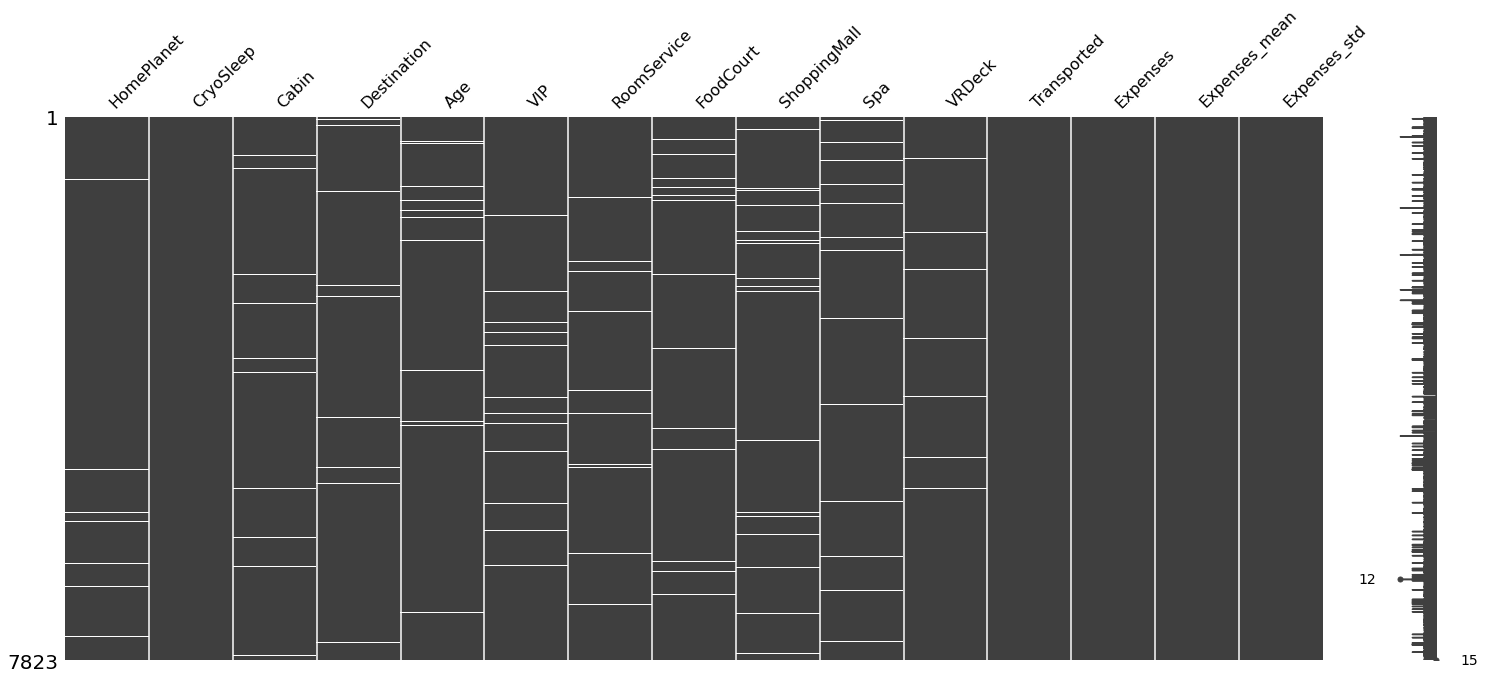

In [9]:
msno.matrix(df)

### Una pregunta válida es: La gente que gasta ('Expenses' > 0) tiene mas chances de salvarse? se contean los casos

In [10]:
print('Gastaron y se salvaron: {}'.format(len(df[(df['Expenses'] > 0) & (df['Transported'] == 0)])))  
print('Gastaron y NO se salvaron: {}'.format(len(df[(df['Expenses'] > 0) & (df['Transported'] == 1)])))
print('NO Gastaron y se salvaron: {}'.format(len(df[(df['Expenses'] == 0) & (df['Transported'] == 0)])))
print('NO Gastaron y NO se salvaron: {}'.format(len(df[(df['Expenses'] == 0) & (df['Transported'] == 1)])))

Gastaron y se salvaron: 3158
Gastaron y NO se salvaron: 1359
NO Gastaron y se salvaron: 701
NO Gastaron y NO se salvaron: 2605


### Es evidente que la gente que gasta dinero en amenities es la que mas se salvó. Ahora, la gente que gastó, pero NO se salvó: es gente que gasta poco? se analiza eso de manera gráfica.

<AxesSubplot:xlabel='Transported', ylabel='Expenses'>

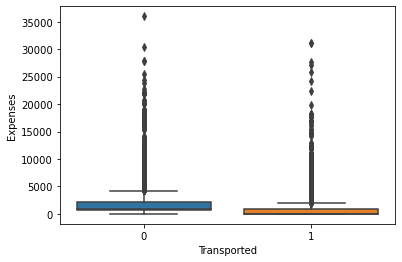

In [11]:
sns.boxplot(x='Transported',y='Expenses',data=df)

### No se observa que haya una diferencia clara que que la gente que gasta menos se teletransporte mas. Incluso el rango intercuartílico delos que se salvaron es mayor al de los que no se salvaron. CONCLUSION: Gastar dinero si es una feature 'gatillo' del tipo salvarse SI o NO, pero no se anticipa que haya una correlación cuantitativa entre cuanto gastó y la posibilidad de salvarse. Eso implica que a los valores en las distintas categorias de amenities los puedo asignar con 0 sin afectar alguna capacidad predictiva.

In [12]:
columns_to_fill = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

<AxesSubplot:>

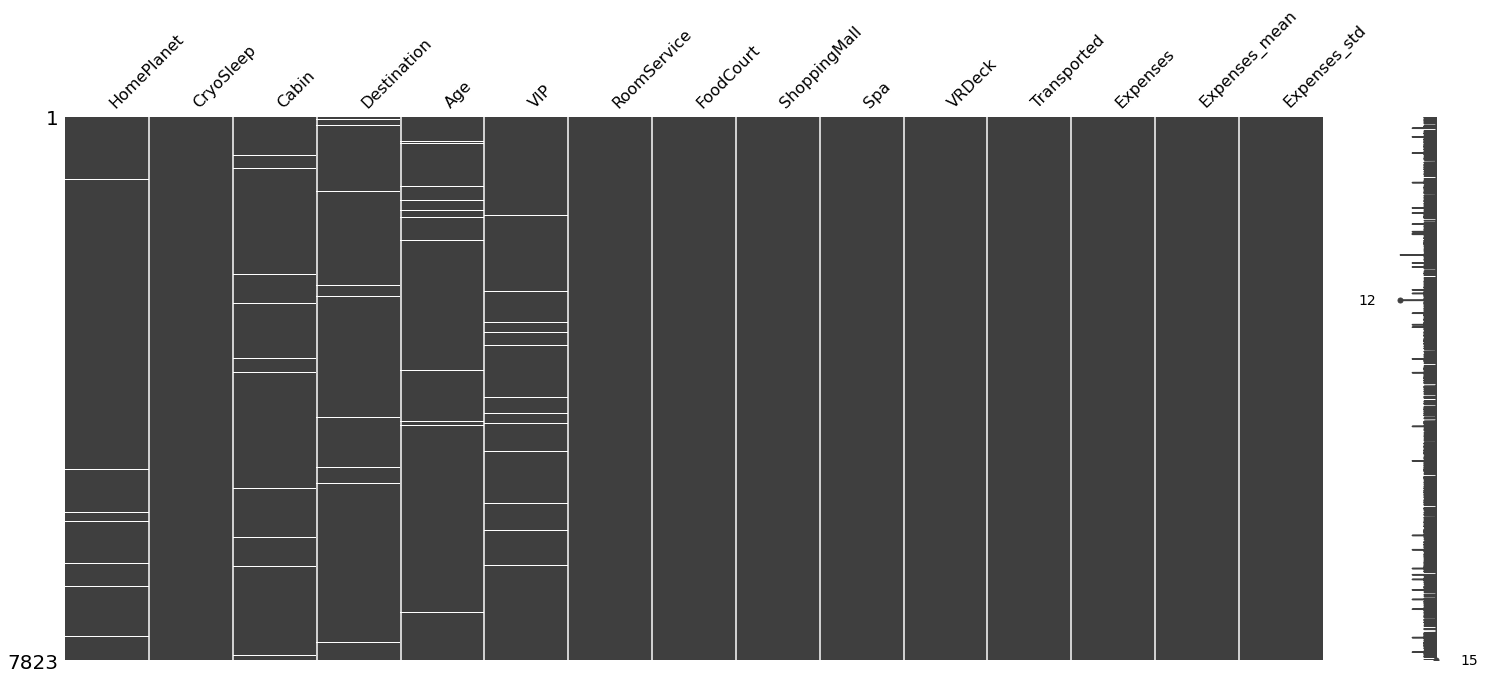

In [13]:
msno.matrix(df)

### Ahora se desacoplan datos de la columna 'Cabin'. Existen datos respeto de la ubicacion del pasajero que pueden ser útiles a los fines del aprendizaje


In [14]:
df[['Deck','Num','Side']] = df['Cabin'].str.split('/',expand=True)
df.columns

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'Expenses', 'Expenses_mean', 'Expenses_std', 'Deck',
       'Num', 'Side'],
      dtype='object')

### Vemos que los pasajeros VIP son muy poco en relación a los pasajeros NO VIP, con lo cual es seguro imputar como 'FALSE' los datos faltantes en VIP.

In [15]:
df['VIP'] = df['VIP'].fillna(False)

<AxesSubplot:>

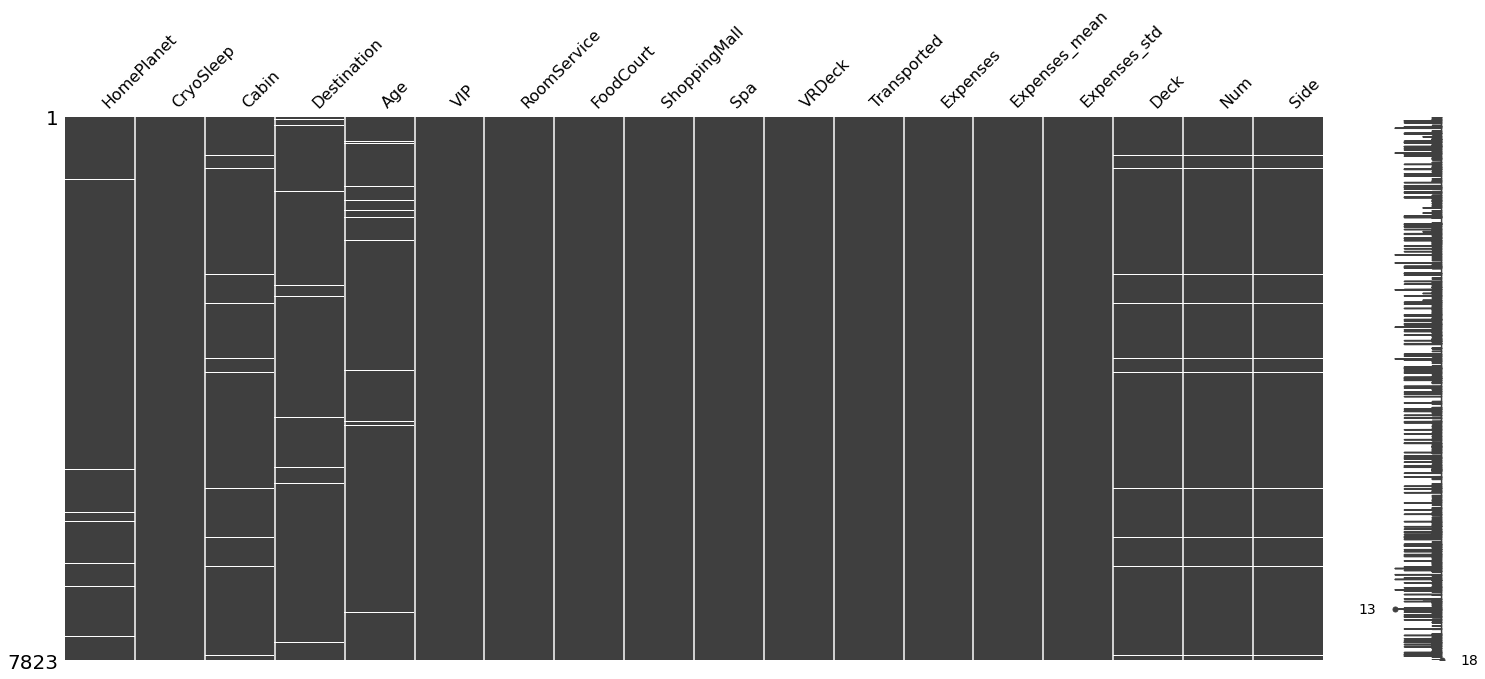

In [16]:
msno.matrix(df)

### Ahora vamos a imputar los valores de Edad: Primero vemos la distrbución de los datos, los cuales se parecen a una dist normal con una leve disminución en la franja de niños entre 5-10 años. Por ello, imputar por edad promedio está bien, pero además podemos considerar edades promedios independientes para la población de pasajeros VIP y no VIP. Imputamos cada subpoblación con su media.

28.879389113692728
27.0


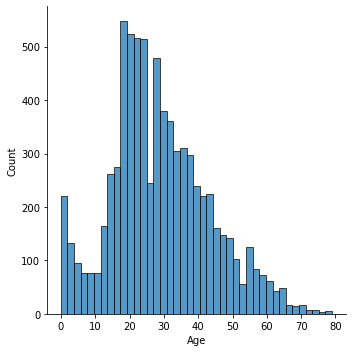

In [17]:
print(df['Age'].mean())
print(df['Age'].median())
sns.displot(df,x='Age')

In [18]:
df_VIP = df[df['VIP'] == True]
df_noVIP = df[df['VIP'] == False]
media_VIP = df_VIP['Age'].mean()
media_noVIP = df_noVIP['Age'].mean()

df.Age.fillna(-1, inplace=True)

def fill_age(x, y):
    if x == -1 and y == True:
        return media_VIP
    elif x == -1 and y == False:
        return media_noVIP
    else:
        return x
    
#df['Age'] = df[['Age','VIP']].apply(lambda row: fill_cryo(row['Age'], row['VIP']) , axis=1)

<AxesSubplot:>

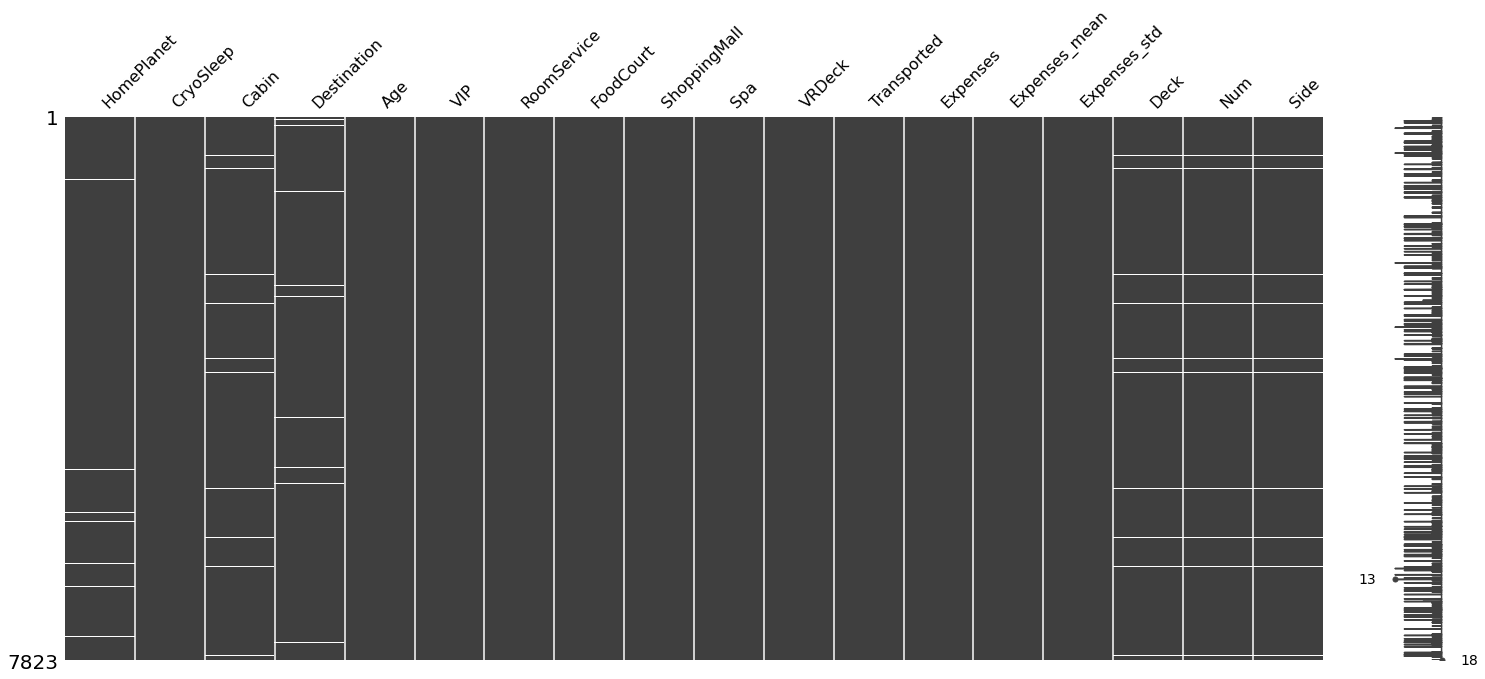

In [19]:
msno.matrix(df)

### Ahora los valores de HomePlanet y Destination los rellenamos confiando en las frecuencias, y asumiento el origen y destino mas frecuente del pasajero.

In [20]:
print(df['HomePlanet'].value_counts())
print(df['Destination'].value_counts())
Homeplanet_value = 'Earth'
Destination_value = 'TRAPPIST-1e'
df.HomePlanet.fillna(Homeplanet_value, inplace=True)
df.Destination.fillna(Destination_value, inplace=True)

Earth     4114
Europa    1935
Mars      1595
Name: HomePlanet, dtype: int64
TRAPPIST-1e      5316
55 Cancri e      1625
PSO J318.5-22     722
Name: Destination, dtype: int64


### Los datos de cabina y sus features desglosadas son imposibles de imputar, atento a que se vió que no hay un patron de ocupación de la nave. Es decir que se vé que no hay Deck o Side que se ocupado por algún tipo de pasajero particular. Entonces se calculan el impacto en cuanto a pérdida de información de estos datos si es que fueran eliminado. Son muy poco datos (2.35%), con lo cual se decide eliminar el dato completo si es que este feature no está presente. Dado que en el dataframe de test se observan datos faltantes de 'Cabin', si esta feature (o sus derivadas) resulta importante para la predicción deberemos reanalizar como imputarla.

In [21]:
features = list(df.columns)

def print_null_values(dataset,features):
    row, column = dataset.shape 
    for feature in features:
        values = dataset[feature].count()
        missing_values = dataset[feature].isnull().sum()
        nan_values = dataset[feature].isna().sum()
        perc = (values / row) * 100
        print("{0} {1} {2} {3:.2f}%".format(feature,values,missing_values,perc))
    
print_null_values(df,features)

HomePlanet 7823 0 100.00%
CryoSleep 7823 0 100.00%
Cabin 7639 184 97.65%
Destination 7823 0 100.00%
Age 7823 0 100.00%
VIP 7823 0 100.00%
RoomService 7823 0 100.00%
FoodCourt 7823 0 100.00%
ShoppingMall 7823 0 100.00%
Spa 7823 0 100.00%
VRDeck 7823 0 100.00%
Transported 7823 0 100.00%
Expenses 7823 0 100.00%
Expenses_mean 7823 0 100.00%
Expenses_std 7823 0 100.00%
Deck 7639 184 97.65%
Num 7639 184 97.65%
Side 7639 184 97.65%


### Un análisis que se pensó útil fué tratar de discriminar en base a la distribución del pasaje quien son tripulantes de la nave y quienes son pasajeros. Para ello se asumen que los tripulates duermen en cabinas compartidas, mientras que los pasajeros duermen en grupos familiares. Vimos cuantas cabinas hay, y cual es la ocupación de las mismas.

In [22]:
df['Cabin'].value_counts()

G/734/S     8
B/201/P     7
F/1194/P    7
E/13/S      7
G/117/S     6
           ..
B/120/P     1
G/6/S       1
G/80/S      1
G/631/S     1
E/253/P     1
Name: Cabin, Length: 6009, dtype: int64

### Un análisis de la ocupación de la cabina con mas ocupantes (8), que se asume son tripulación de servicio, arroja datos inconsistentes con la lógica de registro del dato de cabina, básicamente porque:

- La misma cabina tiene destinos distintos
- Hay niños en la cabina de 8 años, con lo cual no pueden ser tripulación.
- Hay niños de 4 y 14 años que van a un destino único en la cabina.

In [23]:
df[df['Cabin'] == 'G/734/S']

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Expenses,Expenses_mean,Expenses_std,Deck,Num,Side
1270,Earth,False,G/734/S,TRAPPIST-1e,15.0,False,0.0,893.0,0.0,0.0,0.0,1,893.0,178.6,399.361741,G,734,S
3006,Earth,True,G/734/S,PSO J318.5-22,14.0,False,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.000000,G,734,S
3309,Earth,True,G/734/S,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.000000,G,734,S
3675,Earth,True,G/734/S,PSO J318.5-22,4.0,False,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.000000,G,734,S
4458,Earth,False,G/734/S,TRAPPIST-1e,39.0,False,0.0,2.0,0.0,69.0,836.0,0,907.0,181.4,367.127771,G,734,S
5114,Earth,False,G/734/S,55 Cancri e,11.0,False,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.000000,G,734,S
6049,Earth,False,G/734/S,TRAPPIST-1e,11.0,False,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.000000,G,734,S
6258,Earth,False,G/734/S,TRAPPIST-1e,7.0,False,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.000000,G,734,S


### Vamos un análisis del feature 'Age', el cual se anticipa como importante dado que:
- Los niños deberían ser salvados con prioridad, por lo que taggear por grupos, que incluye menos de edad es relevante,
- Gente mas jóven tiene mas posibilidades de escapar que gente mayor,

### Para incorporar estas descripciones se separa en bins de edades,

<AxesSubplot:xlabel='Age', ylabel='Count'>

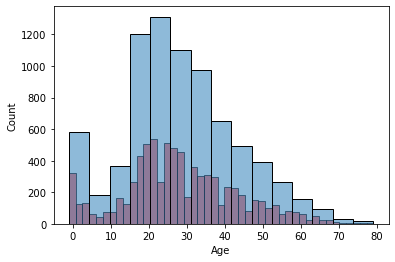

In [24]:
#Un aspecto importante a determinar es el número de bins para capturar la distribución del set. Bins 15 captura bien, sobre todo la caída
# de poblacion en el rango 5-12 años
sns.histplot(x='Age', data=df, color='red',alpha=0.5)
sns.histplot(x='Age', data=df, bins=15,alpha=0.5)

In [25]:
number_of_bins = 15
def age_band(dataset, bins = number_of_bins):
    labels = range(bins)
    return pd.cut(dataset['Age'], bins=bins, labels=labels)

df['AgeBand'] = age_band(df,number_of_bins+1).astype('int')
df['AgeBand'].value_counts()

4     1336
5     1153
3      958
6      835
7      729
0      581
8      564
9      381
2      368
10     290
11     219
1      182
12     133
13      52
14      28
15      14
Name: AgeBand, dtype: int64

In [26]:
# Sin embargo los menores de edad no parecen tener mayores porcentaje de salvarse. Ser mayor si parece ser favorable a salvarse.
age_band=1
for age_band in range(number_of_bins+1):
    salvados = len(df[(df['AgeBand'] == age_band) & (df['Transported'] == 0)])
    total = len(df[df['AgeBand'] == age_band])
    porcentaje = salvados * 100 / total
    print('AgeBand: {}, salvados: {}%'.format(age_band,porcentaje))

AgeBand: 0, salvados: 30.464716006884682%
AgeBand: 1, salvados: 40.65934065934066%
AgeBand: 2, salvados: 43.20652173913044%
AgeBand: 3, salvados: 47.18162839248434%
AgeBand: 4, salvados: 55.61377245508982%
AgeBand: 5, salvados: 50.47701647875108%
AgeBand: 6, salvados: 54.37125748502994%
AgeBand: 7, salvados: 52.674897119341566%
AgeBand: 8, salvados: 47.163120567375884%
AgeBand: 9, salvados: 50.13123359580052%
AgeBand: 10, salvados: 52.41379310344828%
AgeBand: 11, salvados: 47.48858447488585%
AgeBand: 12, salvados: 50.37593984962406%
AgeBand: 13, salvados: 59.61538461538461%
AgeBand: 14, salvados: 50.0%
AgeBand: 15, salvados: 64.28571428571429%


In [27]:
df_completo = df.dropna().reset_index(drop=True)
df_completo.drop('Cabin',inplace=True,axis=1) # Sacamos la columna Cabin porque ya está representada con sus componentes
df_completo['Age'] = df_completo['Age'].astype(int) # Convertimos la edad a variable numérica
df_completo['Num'] = df_completo['Num'].astype(int) # Convertimos el numero de habitacion a variable numérica
df_completo['CryoSleep'] = df_completo['CryoSleep'].astype(int) # Convertimos CryoSleep 1/0
df_completo['VIP'] = df_completo['VIP'].astype(int) # Convertimos VIP a 1/0

### Una vez que tenemos el dataframe completo, pasamos hacer un OneHotEncoding de las variables categóricas

In [28]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7639 entries, 0 to 7638
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   HomePlanet     7639 non-null   object 
 1   CryoSleep      7639 non-null   int64  
 2   Destination    7639 non-null   object 
 3   Age            7639 non-null   int64  
 4   VIP            7639 non-null   int64  
 5   RoomService    7639 non-null   float64
 6   FoodCourt      7639 non-null   float64
 7   ShoppingMall   7639 non-null   float64
 8   Spa            7639 non-null   float64
 9   VRDeck         7639 non-null   float64
 10  Transported    7639 non-null   int64  
 11  Expenses       7639 non-null   float64
 12  Expenses_mean  7639 non-null   float64
 13  Expenses_std   7639 non-null   float64
 14  Deck           7639 non-null   object 
 15  Num            7639 non-null   int64  
 16  Side           7639 non-null   object 
 17  AgeBand        7639 non-null   int64  
dtypes: float

In [29]:
categorical_values = ['HomePlanet','Destination','Deck','Side']
added_variables_counter=0
for item in categorical_values:
    print(df_completo[item].unique())
    added_variables_counter = added_variables_counter + len(df_completo[item].unique())
    
print('Variables nuevas con OneHotEncoder: {}'.format(added_variables_counter))

['Europa' 'Mars' 'Earth']
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e']
['C' 'F' 'B' 'G' 'E' 'D' 'A' 'T']
['P' 'S']
Variables nuevas con OneHotEncoder: 16


In [30]:
one_hot_enconder = OneHotEncoder()
features_array = one_hot_enconder.fit_transform(df_completo[categorical_values]).toarray()
print(one_hot_enconder.categories_)
features_array

[array(['Earth', 'Europa', 'Mars'], dtype=object), array(['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e'], dtype=object), array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], dtype=object), array(['P', 'S'], dtype=object)]


array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [31]:
# Acá proceso para hacer el dataframe derivado del OneHotEncoder
feature_labels = one_hot_enconder.categories_ # obtengo las categorias de la instacia del encoder
feature_labels = np.hstack(feature_labels) # esto es para obtener un array de una sola fila
encoded_data_df = pd.DataFrame(features_array, columns=feature_labels) # Creo el dataframe con la info encodeada
df_completo_encoded = pd.concat([df_completo,encoded_data_df], axis=1) # Junto las columnas para obtener el dataframe final
df_completo_encoded_listo = df_completo_encoded.drop(categorical_values,axis=1)

## Finalmente se hace un escalado de los datos

In [32]:
df_completo_encoded_listo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7639 entries, 0 to 7638
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CryoSleep      7639 non-null   int64  
 1   Age            7639 non-null   int64  
 2   VIP            7639 non-null   int64  
 3   RoomService    7639 non-null   float64
 4   FoodCourt      7639 non-null   float64
 5   ShoppingMall   7639 non-null   float64
 6   Spa            7639 non-null   float64
 7   VRDeck         7639 non-null   float64
 8   Transported    7639 non-null   int64  
 9   Expenses       7639 non-null   float64
 10  Expenses_mean  7639 non-null   float64
 11  Expenses_std   7639 non-null   float64
 12  Num            7639 non-null   int64  
 13  AgeBand        7639 non-null   int64  
 14  Earth          7639 non-null   float64
 15  Europa         7639 non-null   float64
 16  Mars           7639 non-null   float64
 17  55 Cancri e    7639 non-null   float64
 18  PSO J318

In [33]:
integer_columns = df_completo_encoded_listo.iloc[:,14:].columns.to_list()
for column in integer_columns:
    df_completo_encoded_listo[column] = df_completo_encoded_listo[column].astype(int)

df_completo_encoded_listo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7639 entries, 0 to 7638
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CryoSleep      7639 non-null   int64  
 1   Age            7639 non-null   int64  
 2   VIP            7639 non-null   int64  
 3   RoomService    7639 non-null   float64
 4   FoodCourt      7639 non-null   float64
 5   ShoppingMall   7639 non-null   float64
 6   Spa            7639 non-null   float64
 7   VRDeck         7639 non-null   float64
 8   Transported    7639 non-null   int64  
 9   Expenses       7639 non-null   float64
 10  Expenses_mean  7639 non-null   float64
 11  Expenses_std   7639 non-null   float64
 12  Num            7639 non-null   int64  
 13  AgeBand        7639 non-null   int64  
 14  Earth          7639 non-null   int64  
 15  Europa         7639 non-null   int64  
 16  Mars           7639 non-null   int64  
 17  55 Cancri e    7639 non-null   int64  
 18  PSO J318

In [34]:
mms = MinMaxScaler()

columns_to_rescale = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck',
                      'Expenses','Expenses_mean','Expenses_std','AgeBand']

#df_completo_encoded_listo['Age']

#df_completo_encoded_listo['Age'] = mms.fit_transform(df_completo_encoded_listo['Age'].values.reshape(-1,1))

for column in columns_to_rescale:
    print(column)
    df_completo_encoded_listo[column] = mms.fit_transform(df_completo_encoded_listo[column].values.reshape(-1,1))

Age
RoomService
FoodCourt
ShoppingMall
Spa
VRDeck
Expenses
Expenses_mean
Expenses_std
AgeBand


In [35]:
X = df_completo_encoded_listo.drop('Transported',axis=1)
y = df_completo_encoded_listo.Transported
print(X.shape)
print(y.shape)


(7639, 29)
(7639,)


## Experimentación con modelos de clasificación

In [36]:
### Separamos en dataframe en test y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 42)

Usando la funcion "feature_importances_" de RandomForest, vamos a ver que features son las que más peso tienen en las predicciones, para quedarnos con ellas, y luego utilizar solo estas columnas en las predicciones siguientes.

In [37]:
treshold = 0.02

forest = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=42)
forest.fit(X_train,y_train)

importances = forest.feature_importances_
indexes = np.argsort(importances)[::-1]

columns = []

for i,f in enumerate(indexes):
    importance = importances[f]
    if importance >= treshold:
        column = X_train.columns[f]
        columns.append(column)
        print("{0:2} {1:30} {2:.2f}".format(i+1,column,importances[f]))

 1 Expenses_mean                  0.15
 2 Expenses_std                   0.14
 3 Expenses                       0.10
 4 CryoSleep                      0.09
 5 Spa                            0.08
 6 FoodCourt                      0.07
 7 RoomService                    0.07
 8 ShoppingMall                   0.05
 9 VRDeck                         0.05
10 Earth                          0.03
11 Europa                         0.03
12 G                              0.02
13 Num                            0.02


Modificamos nuestro train y test con las columnas que obtuvimos del feature_importances.

In [38]:
X_train = X_train[columns]
X_test = X_test[columns]

Ahora vamos a probar distintos modelos con hiperparametros estandar, y luego probaremos optimizar los hiperparametros con RandomSearch y GridSearch. Guardaremos todos los scores en variables distintas, para luego armar un dataframe y poder identificar el mejor score y a que modelo corresponde. Por una cuestión de simplicidad, vamos a quedarnos con la función "score" que viene en los modelos de sklearn, que nos devuelve el valor de R², consideramos que es una métrica razonable para poder comparar los distintos modelos y su performance.

In [39]:
rf = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=42)
rf.fit(X_train,y_train)
acc_rf = round(rf.score(X_test, y_test) * 100, 2)
acc_rf

79.12

In [41]:
catboost = CatBoostClassifier(
    iterations=50,
    random_seed=42,
    learning_rate=0.1,
    custom_loss=['AUC', 'Accuracy']
)

catboost.fit(
    X_train, y_train,
    verbose=False,
    plot=True
)

acc_catboost = round(catboost.score(X_val, y_val) * 100, 2)
acc_catboost

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

80.04

In [42]:
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)
train_predictions = knn.predict(X_train)
acc_knn = round(knn.score(X_val, y_val) * 100, 2)
acc_knn

59.75

In [43]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
acc_gaussian = round(gaussian.score(X_val, y_val) * 100, 2)
acc_gaussian

68.78

In [44]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    nthread=1,verbosity=0)

xgb.fit(X_train, y_train)
acc_xgb = round(xgb.score(X_val, y_val) * 100, 2)
acc_xgb

79.58

In [45]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train, y_train), verbose=3, random_state=42 )

# Here we go
random_search.fit(X_train, y_train)
clf = XGBClassifier(**random_search.best_params_,use_label_encoder=False).fit(X_train, y_train)

clf.fit(X_train, y_train)
acc_xgb_rscv = round(clf.score(X_val, y_val) * 100, 2)
acc_xgb_rscv

Fitting 3 folds for each of 5 candidates, totalling 15 fits


80.37

In [46]:
param_grid = {
    "max_depth": [3, 4, 5, 7, 10],
    "learning_rate": [0.2, 0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

xgb_cl = XGBClassifier(objective="binary:logistic",use_label_encoder=False, verbosity = 0)

grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=5)

grid_cv.fit(X_train,y_train)
acc_xgb_gscv = round(grid_cv.score(X_val, y_val) * 100, 2)
acc_xgb_gscv

[CV 1/3] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, subsample=0.8;, score=0.880 total time=   1.8s
[CV 2/3] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=10, subsample=0.8;, score=0.883 total time=   2.2s
[CV 3/3] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.879 total time=   1.7s
[CV 1/3] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.877 total time=   1.7s
[CV 2/3] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.882 total time=   1.9s
[CV 1/3] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6;, score=0.878 total time=   1.6s
[CV 1/3] END colsample_bytree=0.6, gamma=1, max_depth=4, min_child_weight=10, subsample=0.6;, score=0.879 total time=   1.9s
[CV 2/3] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=10, subsample=0.8;, score=0.883 total time=   1.8

79.65

In [48]:
param_grid = {'n_estimators': [200,500],
             'max_depth'   : [3, 10, 20, 30],
             'min_samples_leaf': [0.05, 0.1],
             'max_features': ['sqrt',0.5, 1.0],
             'ccp_alpha': [0, 0.01]
            }


rfc=RandomForestClassifier(
            random_state = 42
        )

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train,y_train)

acc_rf_gscv = round(CV_rfc.score(X_val, y_val) * 100, 2)
acc_rf_gscv

77.55

In [50]:
models = {'XGboost':XGBClassifier(verbosity = 0),
           'gbc':GradientBoostingClassifier(),
           'ridge':RidgeClassifier(),
           'lr':LogisticRegression()}

estimators = [('XGboost', XGBClassifier(verbosity = 0)), ('gbc', GradientBoostingClassifier()),  ('lr', LogisticRegression())]
modelVC = VotingClassifier(estimators=estimators, voting='soft', weights=[1, 1, 1])
modelVC.fit(X_train,y_train)

acc_voting = round(modelVC.score(X_val, y_val) * 100, 2)
acc_voting

79.78

In [51]:
modelLGBM=LGBMClassifier(max_depth=6, random_state=42, metric='None', n_jobs=6)

modelLGBM.fit(X_train,y_train)
acc_lgbm = round(modelLGBM.score(X_val, y_val) * 100, 2)
acc_lgbm

79.97

In [52]:
model = LGBMClassifier()
param_grid = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'num_leaves': [50, 100, 200],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20]
}

# Init Grid Search
grid_cv_lgmb = GridSearchCV(model, param_grid, n_jobs=-1, cv=3)

grid_cv_lgmb.fit(X_train,y_train)

acc_lgbm_cv = round(grid_cv_lgmb.score(X_val, y_val) * 100, 2)
acc_lgbm_cv

80.17

In [54]:
models = pd.DataFrame({
    'Model': ['RandomForest','CatBoost', 'KNN', 'Guassian', 
              'XGBoost RSCV', 'XGboost GSCV', 'RandomForest GSCV', 
              'Voting Classifier', 'LightGBM', 
              'LightGBM GSCV'],
    'Score': [acc_rf, acc_catboost, acc_knn, acc_gaussian, 
              acc_xgb_rscv, acc_xgb_gscv, acc_rf_gscv, 
              acc_voting, acc_lgbm, acc_lgbm_cv]})
models.sort_values(by='Score', ascending=False)

,Model,Score
4,XGBoost RSCV,80.37
9,LightGBM GSCV,80.17
1,CatBoost,80.04
8,LightGBM,79.97
7,Voting Classifier,79.78
5,XGboost GSCV,79.65
0,RandomForest,79.12
6,RandomForest GSCV,77.55
3,Guassian,68.78
2,KNN,59.75
